In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    For a given observation, compute Q values for each action
        Attributes
    ----------
    lr: float
        learning rate
    input_dims : list
        [8]
    fc1_dims : int
        fully-connected layer 1
    fc2_dims : int
        fully-connected layer 2
    n_actions : int
        the number of actions
    """
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, weight_decay=1e-5,p=0.5):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
#        self.dropout = nn.Dropout(p) 
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
#        self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss() # Huber loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
#        x = self.dropout(x) # dropout for regularization
        actions = self.fc3(x)
        
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=1e-5, weight_decay=1e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)] # list of actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                  fc1_dims=32, fc2_dims=32, weight_decay=weight_decay)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype= np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # residual. The memory is finite, so we are reusing
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] =  action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device) # [] is used because of the nn library. torch.Size([1, 6])
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item() # .item() to get integer
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size) 
        # select samples the number of self.batch_size out of max_mem 
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Don't select the same thing again
        # array slicing [0,1,2,...,self.batch_size-1]
        batch_index = np.arange(self.batch_size, dtype=np.int32) 
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
                                                 
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [3]:
from env import TradingSPYEnv
import numpy as np
import os

env = TradingSPYEnv(mode='test', init_invest=100.0, sma_len=[5,25,50,100])
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

agent = Agent(gamma=0.99, epsilon=0.0, batch_size=64, n_actions=num_actions, eps_end=0.01, input_dims = [num_states], lr=0.003,
              weight_decay=1e-5)
state_dict_path = os.path.join(os.getcwd(),'test-huber.pth')
agent.Q_eval.load_state_dict(T.load(state_dict_path))

scores, eps_history = [], []
n_games = 1000


score = 0
done = False
observation = env._get_observation()
if observation.dtype == np.float64:
    observation = observation.astype(np.float32)
while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    if (observation_ is not None): 
        if (observation_.dtype == np.float64):
            observation_ = observation_.astype(np.float32)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
#        agent.learn()
#        observation = observation_
scores.append(score)
eps_history.append(agent.epsilon)

avg_score = np.mean(scores[-100:])

print('average score %.2f' % avg_score,
     'epsilon %.2f ' % agent.epsilon,
     'profit_iteration %.2f ' % info['profit_iteration'],
     'iterations %.2f ' % info['iterations'],
     'long_return %.2f ' % info['long_return']
     )


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  8
Size of Action Space ->  3
average score 6.19 epsilon 0.00  profit_iteration 0.01  iterations 462.00  long_return 1.04 


In [4]:
env = TradingSPYEnv(mode='test', init_invest=100.0, sma_len=[5,25,50,100])
env.current_step

C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


4161

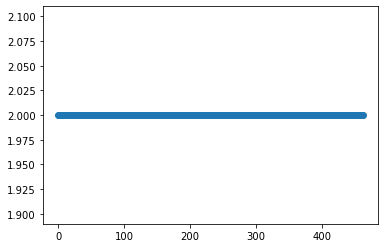

In [9]:
import matplotlib.pyplot as plt
tmp = agent.action_memory[0:462]
plt.scatter(np.arange(len(tmp)),tmp)

In [ ]:
env.features.shape[0]*0.9

In [ ]:
df = env.stock_price_history[['Date','Close']].loc[4161:4623]
df.set_index('Date').plot()

In [ ]:
df2 = env.features[['Date','Close']].loc[4161:4623]
df2.set_index('Date').plot()

In [12]:
np.min(tmp)

2.0